In [75]:
import numpy as np
import netCDF4 as nc
import csv 
import matplotlib.pyplot as plt 
import matplotlib.dates as pltd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from matplotlib.collections import PolyCollection
import pandas
import xarray as xr
import xesmf as xe

In [76]:
# I start with my dictionaries with all the details I want 
file_dir = '/work/Alison.Novara/'

# For now, this is a dictionary containg the file names. 
#     We can add more to it to include details for plots and analyses
organism_dict = {'scallop':{'file_name':'A_irradians', 'plot_title':'$\it{Argopecten}$ $\it{irradians}$'},
                 'pteropod':{'file_name':'L_helicina','plot_title':'$\it{Limacina}$ $\it{helicina}$'},
                 'coral':{'file_name':'P_astreoides','plot_title':'$\it{Porites}$ $\it{astreoides}$'}}

time_periods = ['1975-2014_his',
                '2061-2100_ssp126',
                '2061-2100_ssp245',
                '2061-2100_ssp370',
                '2061-2100_ssp585']

scenario_dict = {'1975-2014_his':{'label':'historical','bar_color':'lightskyblue'},
                '2061-2100_ssp126':{'label':'ssp126','bar_color':'navy'},
                '2061-2100_ssp245':{'label':'ssp245','bar_color':'orange'},
                '2061-2100_ssp370':{'label':'ssp370','bar_color':'red'},
                '2061-2100_ssp585':{'label':'ssp585','bar_color':'maroon'}}

variable_dict = {'aragonite saturation state', 
                 'temperature', 
                 'productivity', 
                 'depth'}

In [80]:
# Here I have chosen to just look at the irradians as a test case for the code. You can sub in any of the files
csv_fil = file_dir + 'A_irradians_range'

location_df = pandas.read_csv(csv_fil)
location_df[['latitude longitude']] = location_df['latitude longitude'].str.split(expand=True)
location_df = location_df.drop(columns='latitude longitude')

organism_locs = xr.Dataset()
organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))


KeyError: 'latitude longitude'

In [ ]:
# Read in the carbonate chemistry files - we're starting with the historical period
ksp_fid = nc.Dataset('co3satarag_1975-2014_his.nc')
co3_fid = nc.Dataset('co3_1975-2014_his.nc')

# extract the variable from the netcdf file. 
co3sat = ksp_fid.variables['co3satarag'][:].squeeze()
co3 = co3_fid.variables['co3'][:].squeeze()

# just using the surface
surf_co3sat = co3sat[:,0,:,:]
surf_co3 = co3[:,0,:,:]

# calculating aragonite saturation state:
#    co3/co3sat = arag saturation state 
surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
surf_arag_sat.fill_value = 0

# geographic information
lat = ksp_fid.variables['lat'][:]
lon = ksp_fid.variables['lon'][:]

# Corner lat/lon for pcolormesh plots
clat = np.append(ksp_fid.variables['lat_bnds'][:,0],ksp_fid.variables['lat_bnds'][-1,-1])
clon = np.append(ksp_fid.variables['lon_bnds'][:,0],ksp_fid.variables['lon_bnds'][-1,-1])

## Making the xarray Datasets for using with the xesmf regridder. 

In [8]:
area_fid = nc.Dataset('areacello_Ofx_GFDL-ESM4_historical_r1i1p1f1_gr.nc')
area = area_fid.variables['areacello'][:]
lsm = area>0

lon = area_fid.variables['lon'][:]
lat = area_fid.variables['lat'][:]
lons,lats = np.meshgrid(lon,lat)
ocean_lons = lons[lsm].ravel()
ocean_lats = lats[lsm].ravel()

# defining the model grid as an xarray Dataset
model_grid = xr.Dataset()

# adding in the information for the geographic coordinates
model_grid["lon"] = xr.DataArray(data=ocean_lons, dims=("location"))
model_grid["lat"] = xr.DataArray(data=ocean_lats, dims=("location"))

esm_to_organism = xe.Regridder(model_grid, organism_locs, 'nearest_s2d',
                               locstream_in=True,locstream_out=True,periodic=True)

depth_fid = nc.Dataset('deptho_Ofx_GFDL-ESM4_historical_r1i1p1f1_gr.nc')
depth = depth_fid.variables['deptho'][:]
depth.fill_value=0

woa_fid = nc.Dataset('/work/Liz.Drenkard/external_data/WOA/1_deg/woa_1x1deg_basin_mask.nc')
woa_mask = woa_fid.variables['basin_mask'][:].squeeze()
# rearrange to go from 0 - 360 longitude to match ESM4 convention
msk_lon = woa_fid.variables['lon'][:]
basin_mask = np.hstack((woa_mask[:,msk_lon>=0],woa_mask[:,msk_lon<0]))
# basin mask: 1= atlantic and arctic, 2 = Pacific, 3 = Indian Oceans

## Getting organism values for aragonite saturation state

In [9]:
organism_surf_arag = esm_to_organism(surf_arag_sat[lsm].ravel()).squeeze()

## Plot distribution of historical mean-state surface aragonite saturation state for this organism


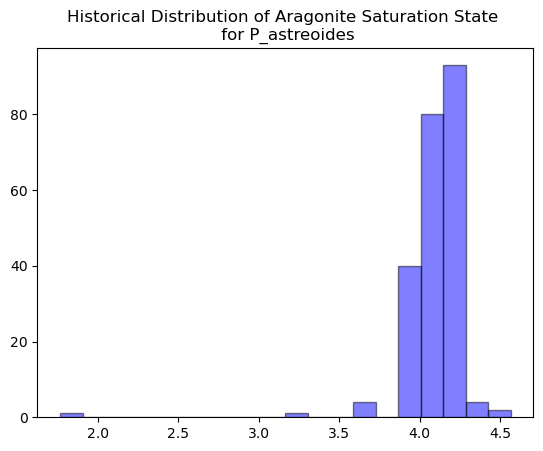

In [10]:
num_bins = 20
n, bins, patches = plt.hist(organism_surf_arag, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Aragonite Saturation State \n for P_astreoides')

In [11]:
def plot_arag_hist(organism, time_periods, ax):
    for time_per in time_periods:
        co3satarag_ncfile = 'co3satarag_' + time_per + '.nc'
        co3_ncfile = 'co3_' + time_per + '.nc'
        
        ksp_fid = nc.Dataset(co3satarag_ncfile)
        co3_fid = nc.Dataset(co3_ncfile)
        
        surf_co3sat = ksp_fid.variables['co3satarag'][:,0,:,:].squeeze()
        surf_co3 = co3_fid.variables['co3'][:,0,:,:].squeeze()
        
        surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
        surf_arag_sat.fill_value = 0
        
        organism_surf_arag = esm_to_organism(surf_arag_sat[lsm].ravel()).squeeze()
        n, bins, patches = ax.hist(organism_surf_arag, bins=num_bins, 
                               facecolor=scenario_dict[time_per]['bar_color'], 
                               edgecolor = 'black', alpha=0.5, 
                               label = scenario_dict[time_per]['label'])
    title = plt.title(('Historical vs. Projected Distributions of Aragonite Saturation State \n for ' + organism_dict[critter]['plot_title']), fontweight='bold')
    plt.xlabel('Aragonite Saturation State')
    plt.ylabel('# of locations')
    ax.legend

scallop
pteropod
coral


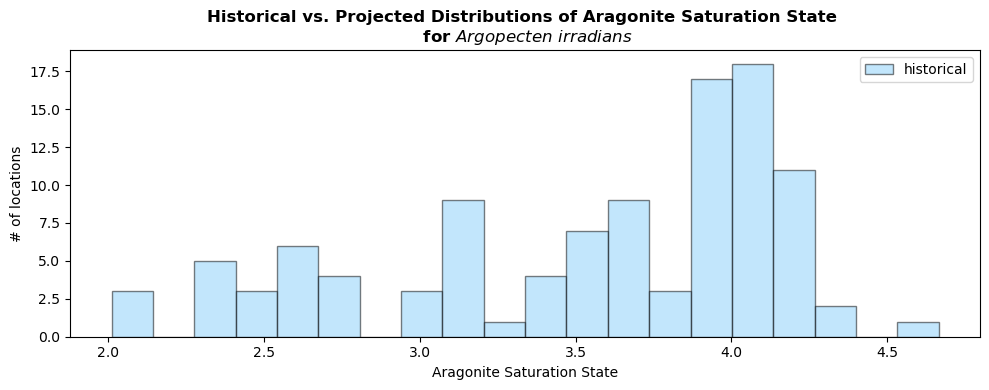

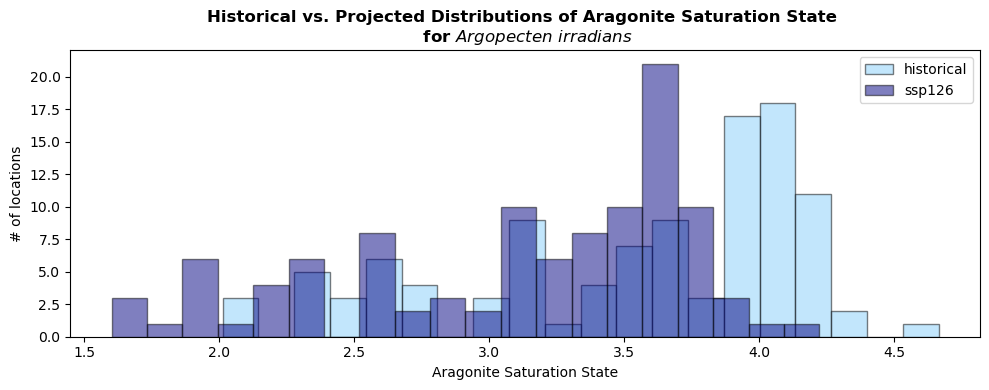

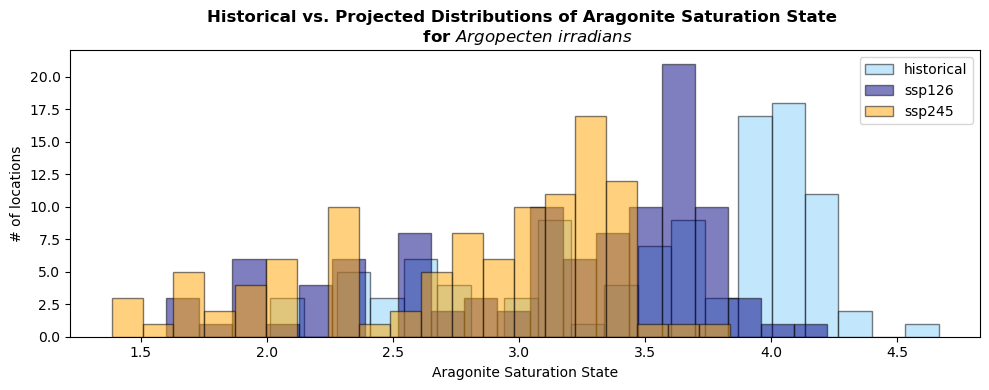

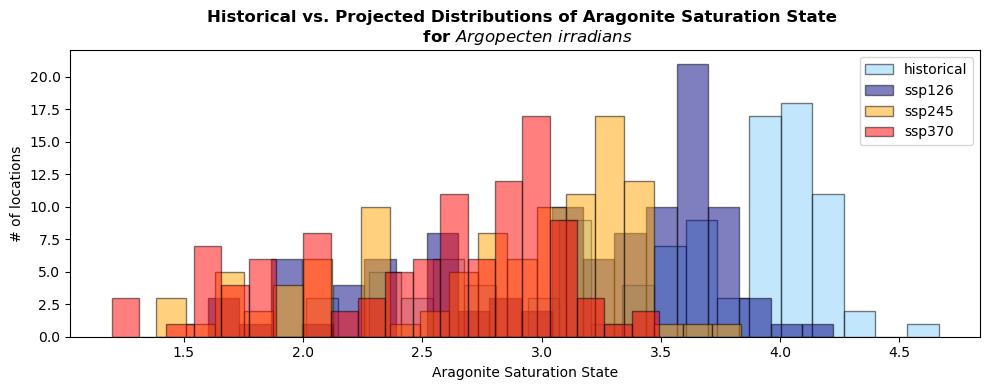

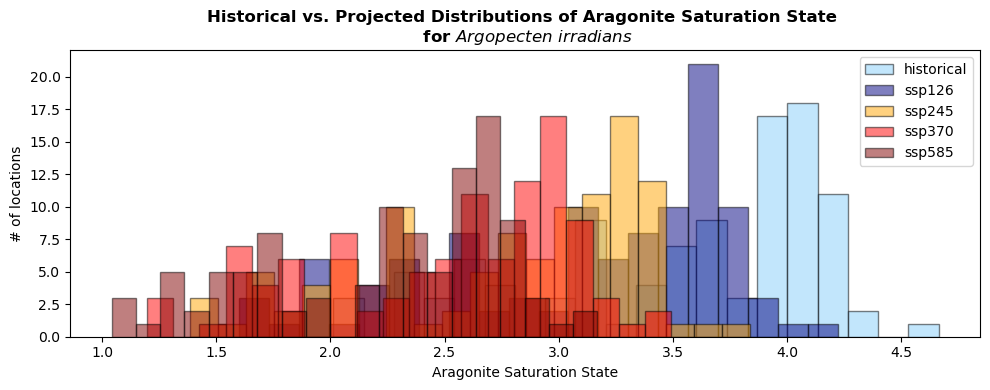

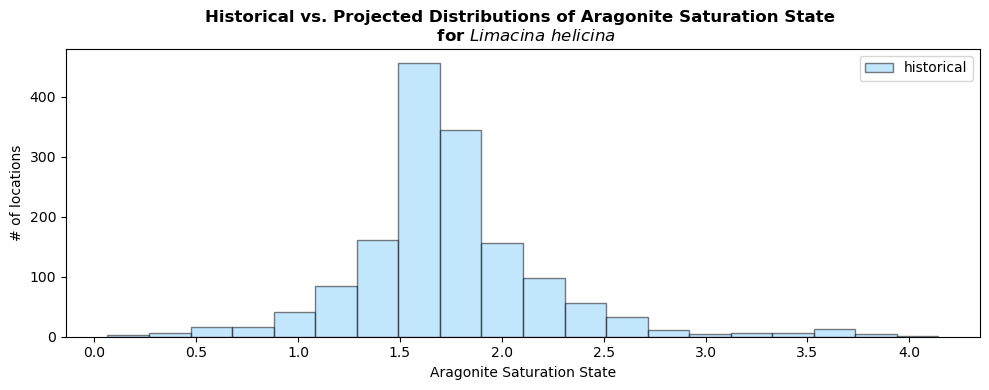

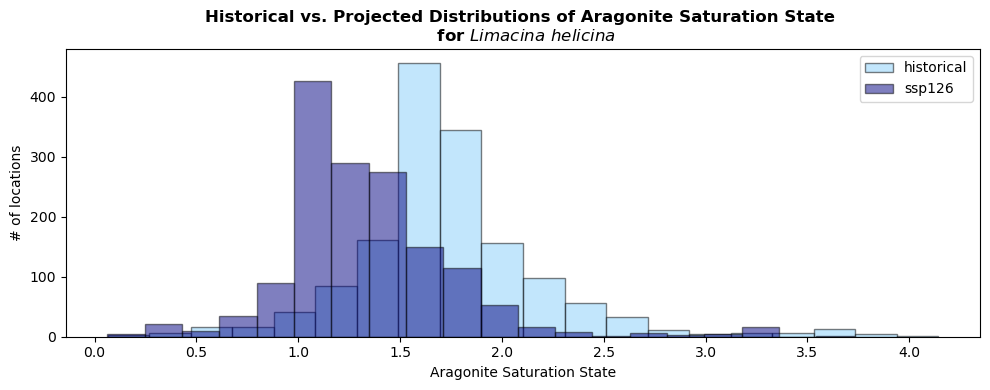

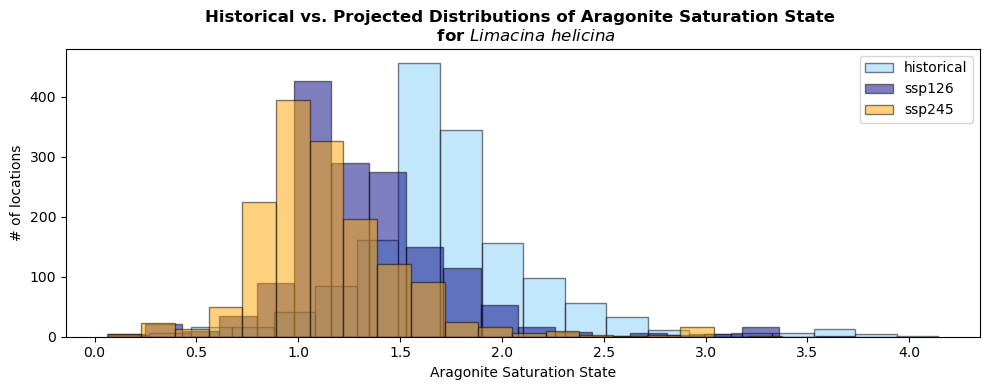

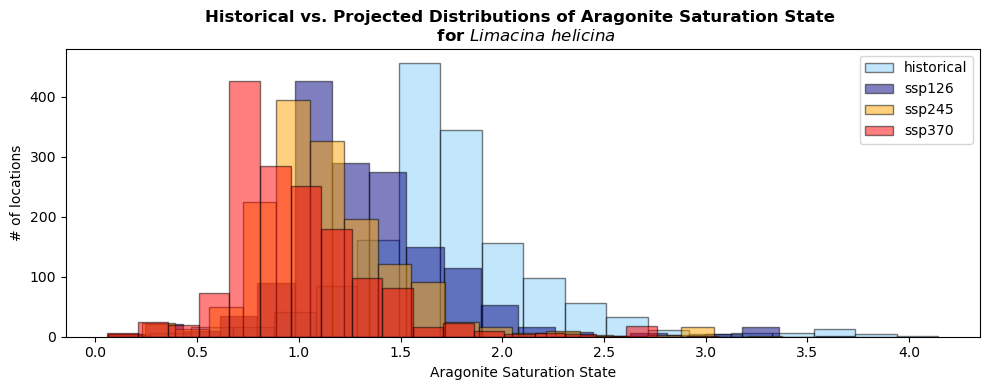

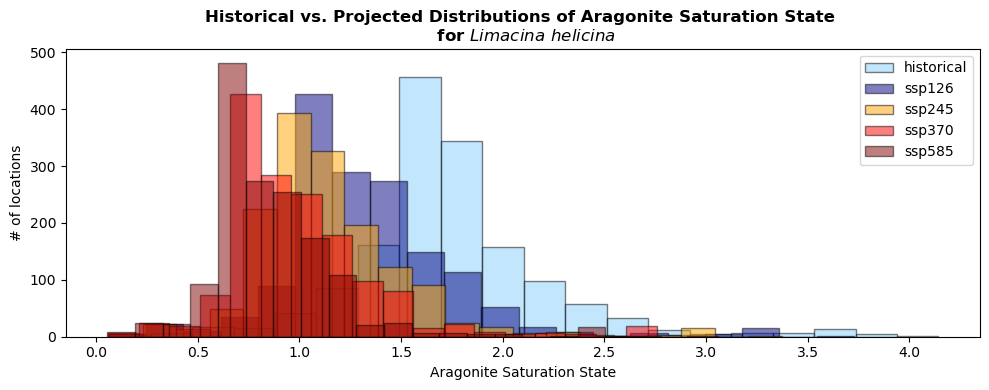

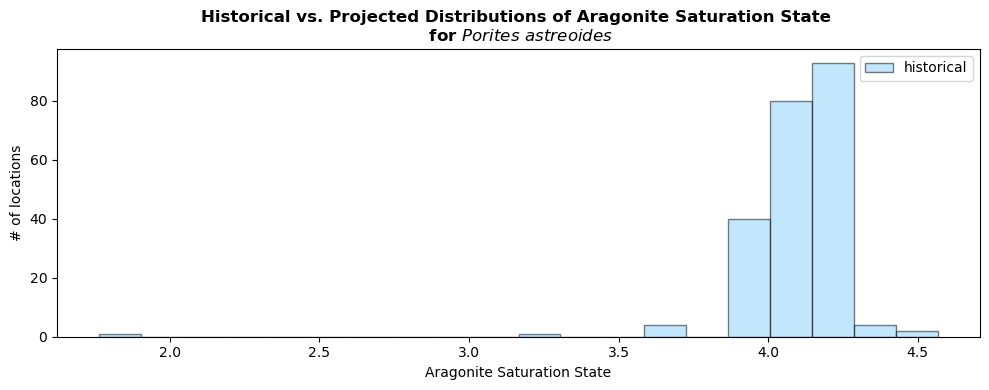

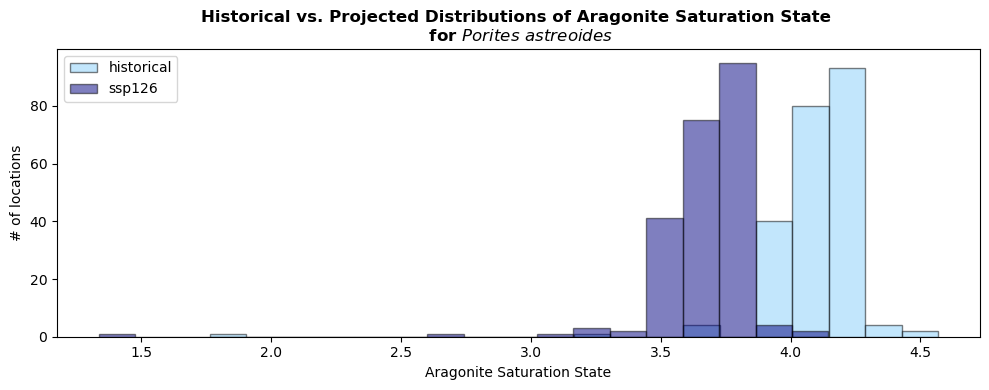

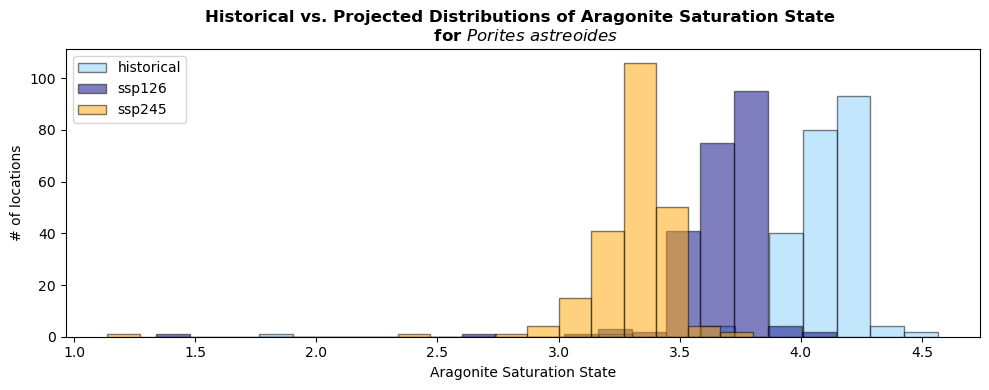

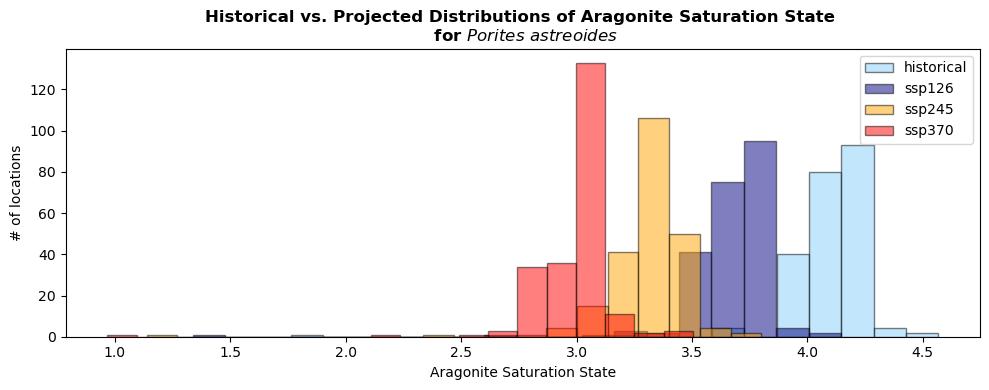

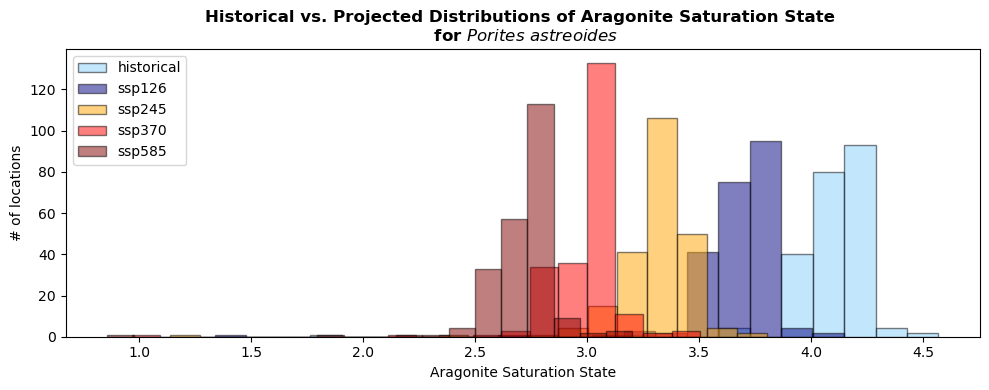

In [12]:
for critter in organism_dict:
    print(critter)
   
    # construct string for file name
    csv_fil = file_dir + organism_dict[critter]['file_name'] + '_range'
    #print(csv_fil)

    # create the pandas dataframe
    if critter == 'scallop':
        location_df = pandas.read_csv(csv_fil)
    else: 
        location_df = pandas.read_csv(csv_fil,delim_whitespace=True)
    
    # extracting the lon/lat variables from the dataframe
    # defining the xarray Dataset for the organism locations
    organism_locs = xr.Dataset()
    organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
    organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))

    
    # Creating the xesmf regridder which will be different for each organism
    esm_to_organism = xe.Regridder(model_grid, organism_locs, 'nearest_s2d',
                               locstream_in=True,locstream_out=True,periodic=True)
    
    num_bins=20
 
    for i in range(len(time_periods)):
        fig, ax = plt.subplots(figsize=(10,4))
        plot_arag_hist(critter, time_periods[:i+1], ax)
        ax.set_title(f'Historical vs. Projected Distributions of Aragonite Saturation State \n for ' + organism_dict[critter]['plot_title'], fontweight='bold')
        ax.legend()
        plt.tight_layout()

## Habitat range plot thoughts for saturation state:
### I think the saturation state criteria for this organism should be "greater than 2" because higher saturation state is not a bad thing

In [13]:
# Read in the historical temperature files 
temp_fid = nc.Dataset('thetao_1975-2014_his.nc')
surf_temp = temp_fid.variables['thetao'][:, 0, :, :].squeeze()


# calculating average historical surface temperature:
surf_temp_mean = np.mean(surf_temp,axis=0)
surf_temp_mean.fill_value = 0

# using the redridder we made above:
organism_sst = esm_to_organism(surf_temp_mean[lsm].ravel()).squeeze()

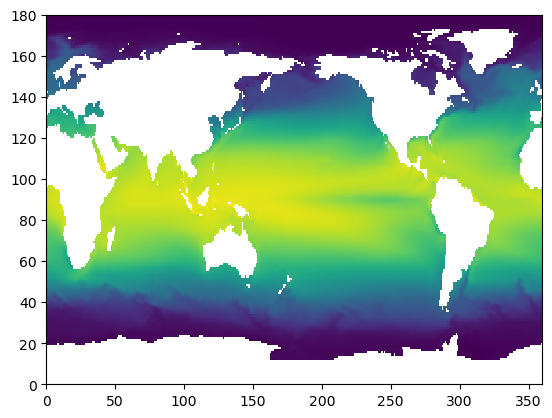

In [14]:
plt.pcolormesh(surf_temp_mean)

(0.0, 15.0)

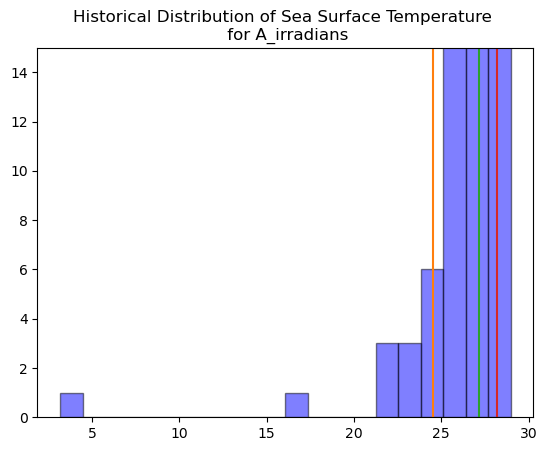

In [15]:
num_bins = 20
n, bins, patches = plt.hist(organism_sst, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Sea Surface Temperature \n for A_irradians')

a=np.quantile(organism_sst,.05)
b=np.quantile(organism_sst,.5)
c=np.quantile(organism_sst,.95)

# plotting quantiles
plt.plot(np.ones(2)*a,(0,20))
plt.plot(np.ones(2)*b,(0,20))
plt.plot(np.ones(2)*c,(0,20))

plt.ylim(0,15)

In [16]:
a

24.505552164713542

In [17]:
c

28.2149169921875

## Habitat range plot thoughts for temperature:
### I think the sst criteria for this organism should be something like "between 11 and 28" kindof rounding up to the nearest degree C

In [18]:
# Read in the historical temperature files 
intpp_fid = nc.Dataset('intpp_1975-2014_his.nc')
intpp = intpp_fid.variables['intpp'][:].squeeze()

# calculating average historical surface temperature:
intpp_mean = np.mean(intpp,axis=0)
intpp_mean.fill_value = 0

# using the redridder we made above:
organism_intpp = esm_to_organism(intpp_mean[lsm].ravel()).squeeze()

(0.0, 15.0)

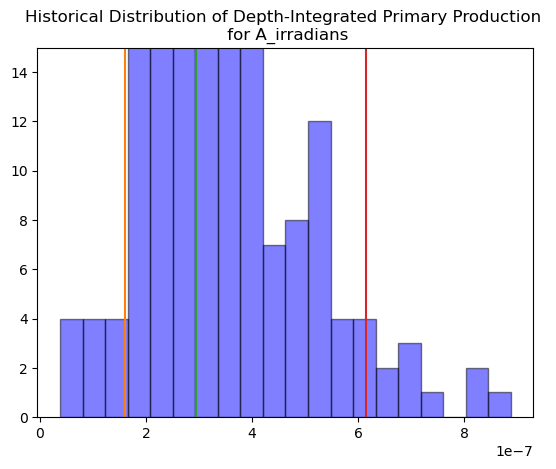

In [19]:
num_bins = 20
n, bins, patches = plt.hist(organism_intpp, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Depth-Integrated Primary Production \n for A_irradians')

a=np.quantile(organism_intpp,.05)
b=np.quantile(organism_intpp,.5)
c=np.quantile(organism_intpp,.95)

# plotting quantiles
plt.plot(np.ones(2)*a,(0,20))
plt.plot(np.ones(2)*b,(0,20))
plt.plot(np.ones(2)*c,(0,20))

plt.ylim(0,15)

In [20]:
a

1.6124515544409712e-07

In [21]:
c

6.153634240035897e-07

### I'm not sure if we should limit production or not... lets see how it looks with just depth, sst, and saturation state

In [22]:
# using the redridder we made above:
organism_depth = esm_to_organism(depth[lsm].ravel()).squeeze()

(0.0, 15.0)

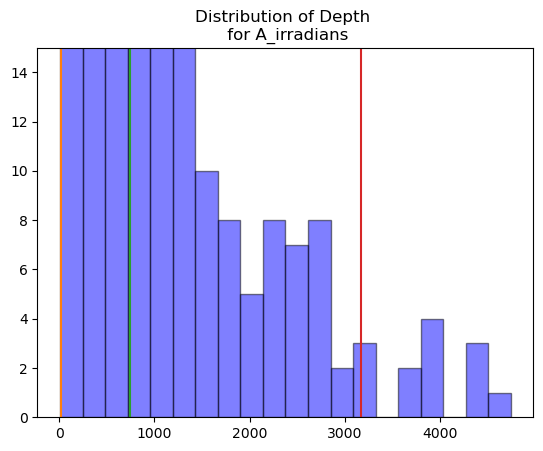

In [23]:
num_bins = 20
n, bins, patches = plt.hist(organism_depth, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Distribution of Depth \n for A_irradians')

a=np.quantile(organism_depth,.05)
b=np.quantile(organism_depth,.5)
c=np.quantile(organism_depth,.95)

# plotting quantiles
plt.plot(np.ones(2)*a,(0,20))
plt.plot(np.ones(2)*b,(0,20))
plt.plot(np.ones(2)*c,(0,20))

plt.ylim(0,15)

## This looks to tend shallow so maybe where depth is less than 700 meters. 

In [24]:
# using the redridder we made above to define the latitude range:
lats.fill_value = 0
organism_lat = esm_to_organism(lats[lsm].ravel()).squeeze()

(0.0, 15.0)

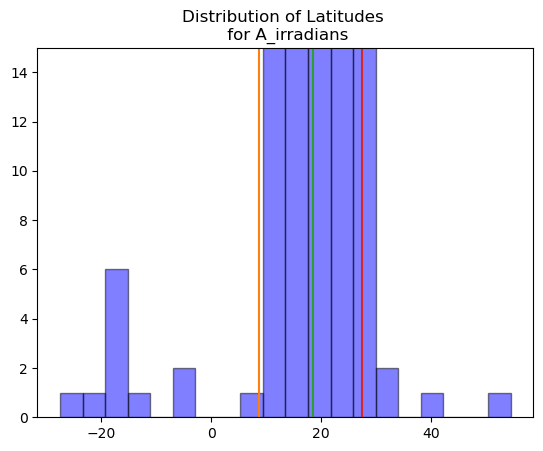

In [25]:
num_bins = 20
n, bins, patches = plt.hist(organism_lat, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Distribution of Latitudes \n for A_irradians')

a=np.quantile(organism_lat,.05)
b=np.quantile(organism_lat,.5)
c=np.quantile(organism_lat,.95)

# plotting quantiles
plt.plot(np.ones(2)*a,(0,20))
plt.plot(np.ones(2)*b,(0,20))
plt.plot(np.ones(2)*c,(0,20))

plt.ylim(0,15)

In [26]:
# using the redridder we made above to define the latitude range:
lons.fill_value = 0
organism_lon = esm_to_organism(lons[lsm].ravel()).squeeze()

(0.0, 15.0)

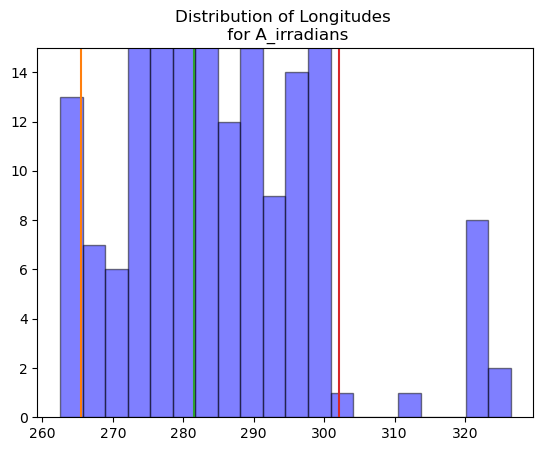

In [27]:
num_bins = 20
n, bins, patches = plt.hist(organism_lon, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Distribution of Longitudes \n for A_irradians')

a=np.quantile(organism_lon,.05)
b=np.quantile(organism_lon,.5)
c=np.quantile(organism_lon,.95)

# plotting quantiles
plt.plot(np.ones(2)*a,(0,20))
plt.plot(np.ones(2)*b,(0,20))
plt.plot(np.ones(2)*c,(0,20))

plt.ylim(0,15)

## I think we can drop the madagascar value and just go with lons between 250 and 300

## Generating the index for the habitat:
#### I've divided this into "geographic indexing" and "environmental indexing" but they all get multiplied together so it's no necessary to do this. The limits on latitude and longitude are not necessarily strict, it's more to prevent habitat ranges to show up on other continents if they aren't present. When considering future changes, you probably want the criteria to permit for values at higher latitudes to be possible. Same with longitudes - if it seems like it would be reasonable that the range would extend east/west as the organism went north (based on projections), you'll want to reconsider the longitude limits

In [28]:
geo_indexing = (depth<700)*(lats>=0)*(lons>250)*(lons<300)*(basin_mask==1)

In [29]:
enviro_indexing = (surf_arag_sat>2)*(surf_temp_mean<28)*(surf_temp_mean>11)

In [30]:
habitat_index = geo_indexing*enviro_indexing

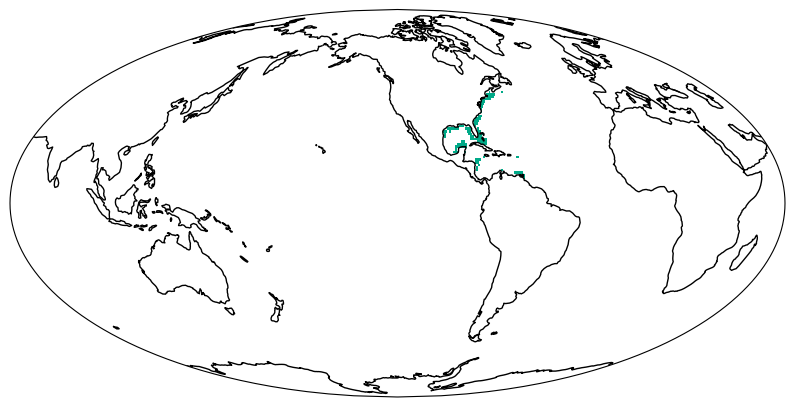

In [31]:
# All possible "Habitat" grid cells
proj = ccrs.Mollweide(central_longitude=240)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()
ax.add_feature(cfeature.COASTLINE,zorder=11)    

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under('white')
P = ax.pcolormesh(clon,clat,habitat_index,vmin=.6,vmax=1.6,cmap=cmap,
                  transform=ccrs.PlateCarree())

plt.setp(ax.spines.values(), color='black',zorder=12)
pos = ax.get_position()


Text(0.5, 1.0, 'All Possible Habitats of Argopecten irradians')

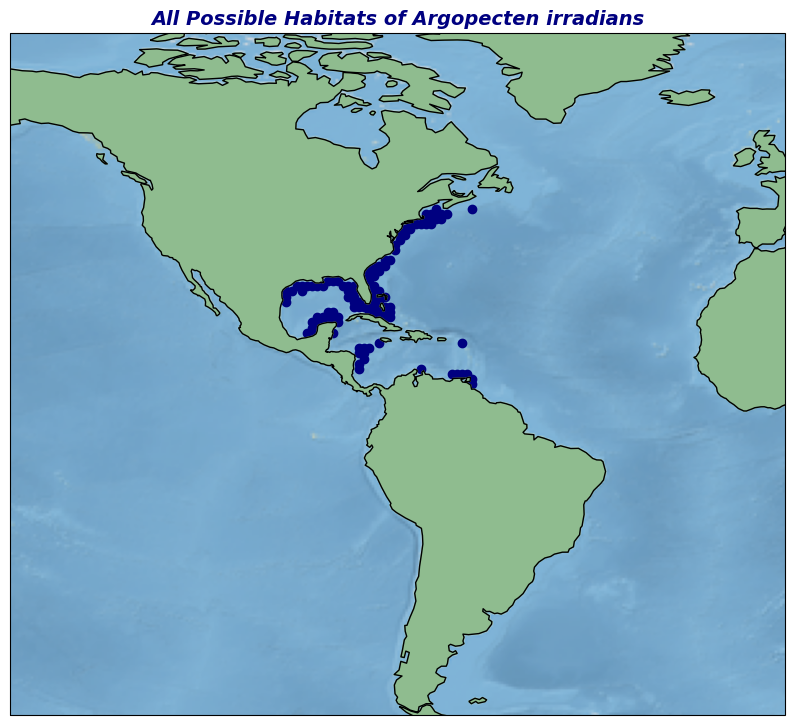

In [72]:
# Alternatively, plot them as individual points 
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()
ax.add_feature(cfeature.COASTLINE,zorder=11)    
ax.add_feature(cfeature.LAND, zorder=10, color='darkseagreen')
P = ax.plot(lons[habitat_index],lats[habitat_index],'o', color='navy',
                  transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent(
    [-150, 0, -20, 50])
 
plt.setp(ax.spines.values(), color='black',zorder=12)
pos = ax.get_position()
plt.title('All Possible Habitats of Argopecten irradians', fontweight='bold', fontstyle='italic', color='navy', fontsize=14)

### We can now take the habitat index and look how 1) these areas are projected to change (same histograms as before but looking at a fuller distribution), 2) where these areas will exist in the future, and 3) what is the percent decrease in area of "suitable habitat" for this organism

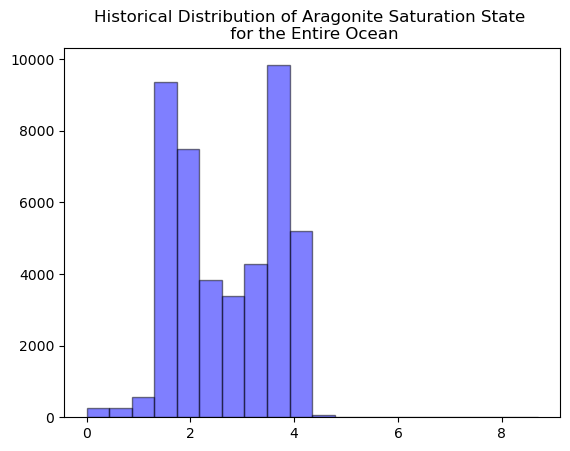

In [33]:
num_bins = 20
n, bins, patches = plt.hist(surf_arag_sat[lsm], num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Aragonite Saturation State \n for the Entire Ocean')

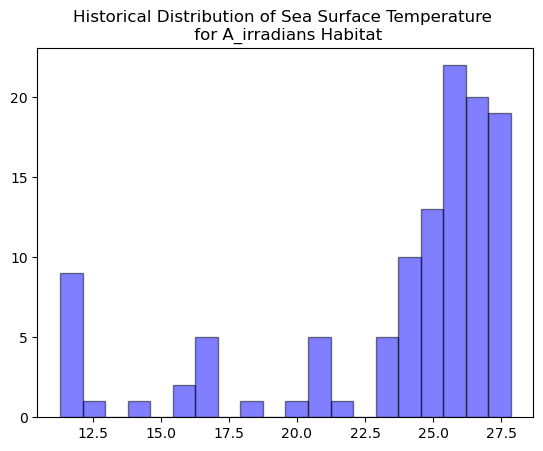

In [34]:
num_bins = 20
n, bins, patches = plt.hist(surf_temp_mean[habitat_index], num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Sea Surface Temperature \n for A_irradians Habitat')

In [50]:
def plot_temp_hist():
    n, bins, patches = ax.hist(organism_sst, num_bins,facecolor=scenario_dict[time_per]['bar_color'], edgecolor = 'black', alpha=0.5, label = scenario_dict[time_per]['label'])
    title = plt.title(('Historical vs. Projected Distributions of Temperature (°C) \n for ' + organism_dict[critter]['plot_title']),fontweight='bold')
    plt.xlabel('Temperature °C')
    plt.ylabel('# of locations')
    ax.legend()

scallop
pteropod
coral


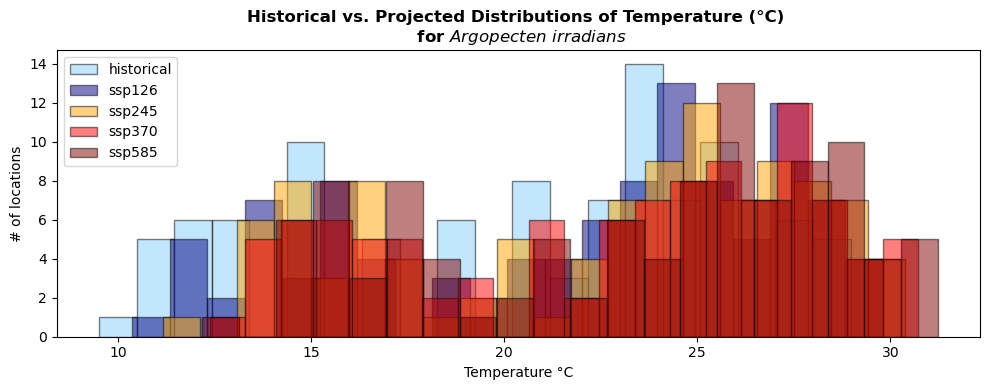

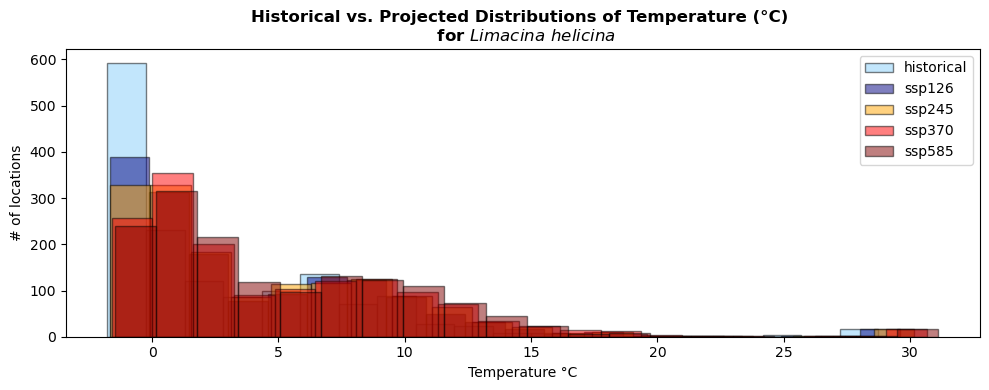

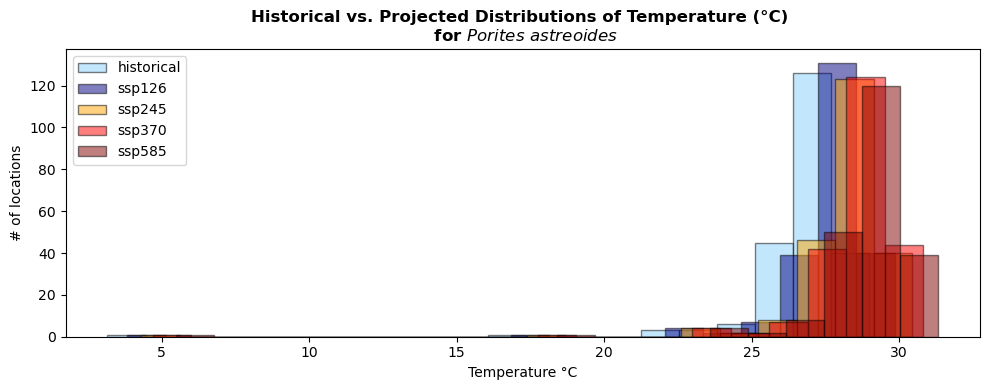

In [51]:
        
for critter in organism_dict:
    print(critter)
   
    # construct string for file name
    csv_fil = file_dir + organism_dict[critter]['file_name'] + '_range'
    #print(csv_fil)

    # create the pandas dataframe
    if critter == 'scallop':
        location_df = pandas.read_csv(csv_fil)
    else: 
        location_df = pandas.read_csv(csv_fil,delim_whitespace=True)
    # show what's in dataframe df:
    #print(location_df)
    
    # extracting the lon/lat variables from the dataframe
    # defining the xarray Dataset for the organism locations
    organism_locs = xr.Dataset()
    organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
    organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))
    
    # Creating the xesmf regridder which will be different for each organism
    
    esm_to_organism = xe.Regridder(model_grid, organism_locs, 'nearest_s2d',
                              locstream_in=True,locstream_out=True,periodic=True)
 
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot()
    for time_per in time_periods:
        # create the file name string
        thetao_ncfile = 'thetao_' + time_per + '.nc'
        
        # create the netCDF file id 
        thetao_fid = nc.Dataset(thetao_ncfile)

        # extract the variable from the netcdf file. 
        surf_temp = thetao_fid.variables['thetao'][:,0,:,:].squeeze()
         
        surf_temp_mean = np.mean(surf_temp,axis=0)   
        surf_temp_mean.fill_value = 0
        
        organism_sst = esm_to_organism(surf_temp_mean[lsm].ravel()).squeeze()
        plot_temp_hist()
        
    plt.legend()
    plt.tight_layout()

In [52]:
def plot_intpp_hist():
    n, bins, patches = ax.hist(organism_intpp, num_bins,facecolor=scenario_dict[time_per]['bar_color'], edgecolor = 'black', alpha=0.5, label = scenario_dict[time_per]['label'])
    title = plt.title(('Historical vs. Projected Distributions of Productivity \n for ' + organism_dict[critter]['plot_title']),fontweight='bold')
    plt.xlabel("Productivity (g C/ $\mathregular{m^{2}}{s^{1}}$)")
    plt.ylabel('# of locations')
    ax.legend()

scallop
pteropod
coral


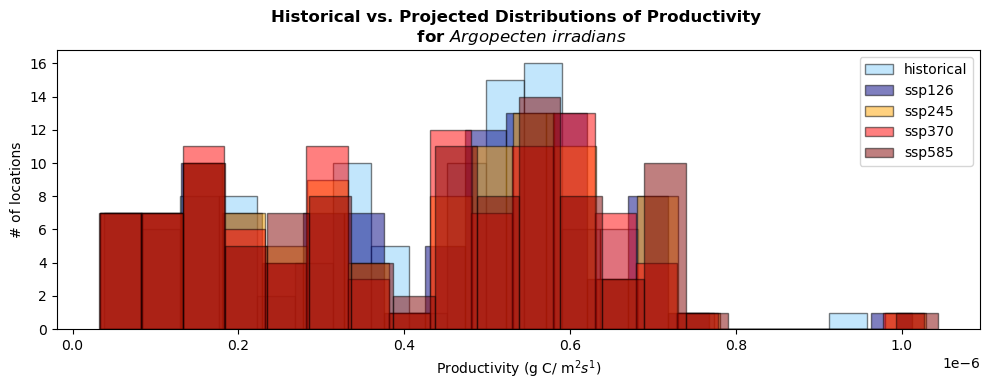

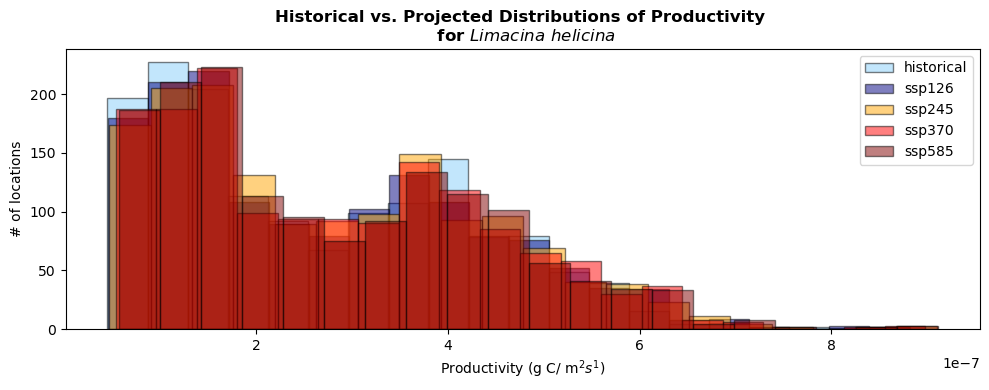

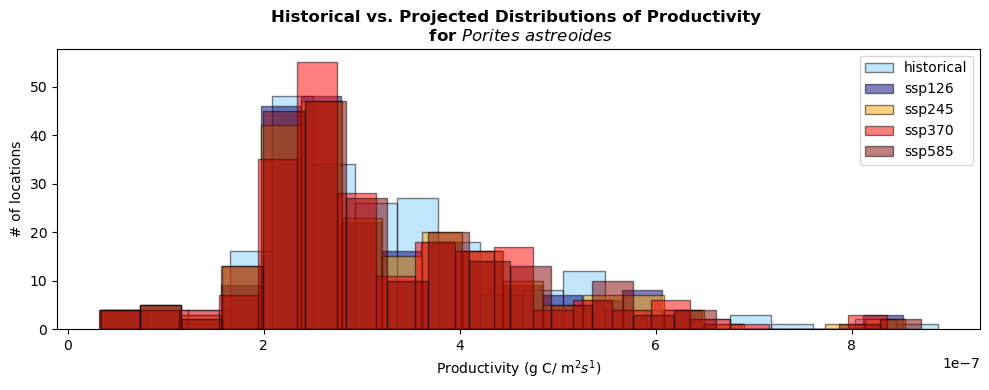

In [54]:
for critter in organism_dict:
    print(critter)
   
    # construct string for file name
    csv_fil = file_dir + organism_dict[critter]['file_name'] + '_range'
    #print(csv_fil)

    # create the pandas dataframe
    if critter == 'scallop':
        location_df = pandas.read_csv(csv_fil)
    else: 
        location_df = pandas.read_csv(csv_fil,delim_whitespace=True)
    # show what's in dataframe df:
    #print(location_df)
    
    # extracting the lon/lat variables from the dataframe
    # defining the xarray Dataset for the organism locations
    organism_locs = xr.Dataset()
    organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
    organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))
    
    # Creating the xesmf regridder which will be different for each organism
    
    esm_to_organism = xe.Regridder(model_grid, organism_locs, 'nearest_s2d',
                              locstream_in=True,locstream_out=True,periodic=True)

    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot()
    for time_per in time_periods:
        # create the file name string
        intpp_ncfile = 'intpp_' + time_per + '.nc'
        
        # create the netCDF file id 
        intpp_fid = nc.Dataset(intpp_ncfile)

        # extract the variable from the netcdf file. 
        intpp = intpp_fid.variables['intpp'][:].squeeze()
         
        intpp_mean = np.mean(intpp,axis=0)
        intpp_mean.fill_value = 0
        
        organism_intpp = esm_to_organism(intpp_mean[lsm].ravel()).squeeze()
        plot_intpp_hist()
    plt.legend()
    plt.tight_layout()

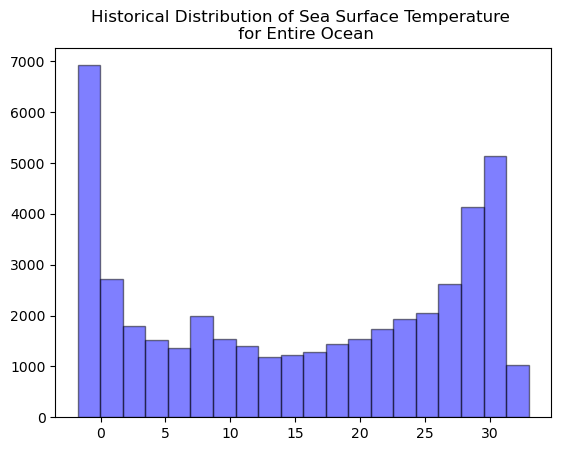

In [55]:
num_bins = 20
n, bins, patches = plt.hist(surf_temp_mean[lsm], num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Sea Surface Temperature \n for Entire Ocean')

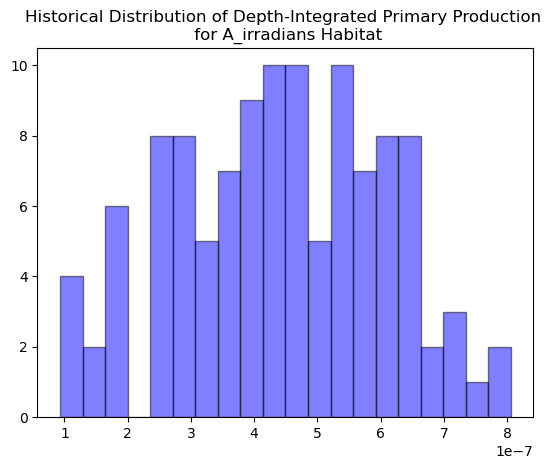

In [56]:
num_bins = 20
n, bins, patches = plt.hist(intpp_mean[habitat_index], num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Depth-Integrated Primary Production \n for A_irradians Habitat')

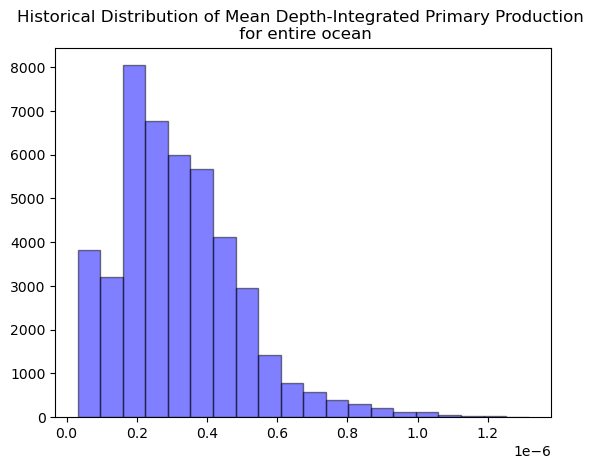

In [57]:
num_bins = 20
n, bins, patches = plt.hist(intpp_mean[lsm], num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Mean Depth-Integrated Primary Production \n for entire ocean')

#### We can look at the total area of "suitable habitat" by taking the habitat index and using it to select for the grid cell area and add them up

In [58]:
his_total_habitat_area = np.sum(area[habitat_index])

In [59]:
his_total_habitat_area # square meters - you can convert this to kilometers or other metrics

1220051000000.0

### Now we can look at future values again

In [61]:
# Read in the carbonate chemistry files - we're starting with the historical period
ksp_fid = nc.Dataset('co3satarag_2061-2100_ssp585.nc')
co3_fid = nc.Dataset('co3_2061-2100_ssp585.nc')

# extract the variable from the netcdf file. 
co3sat_fut = ksp_fid.variables['co3satarag'][:].squeeze()
co3_fut = co3_fid.variables['co3'][:].squeeze()

# just using the surface
surf_co3sat_fut = co3sat_fut[:,0,:,:]
surf_co3_fut = co3_fut[:,0,:,:]

# calculating aragonite saturation state:
#    co3/co3sat = arag saturation state 
surf_arag_sat_fut = np.mean(surf_co3_fut/surf_co3sat_fut,axis=0)
surf_arag_sat_fut.fill_value = 0


In [62]:
# Read in the carbonate chemistry files - we're starting with the historical period
thetao_fid = nc.Dataset('thetao_2061-2100_ssp585.nc')

# extract the variable from the netcdf file. 
thetao_fut = thetao_fid.variables['thetao'][:].squeeze()

# just using the surface
sst_fut = thetao_fut[:,0,:,:]

sst_mean_fut = np.mean(sst_fut,axis=0)
sst_mean_fut.fill_value = 0


In [63]:
geo_indexing = (depth<700)*(lats>=0)*(lons>250)*(lons<300)*(basin_mask==1)

In [64]:
enviro_indexing_fut = (surf_arag_sat_fut>2)*(sst_mean_fut<28)*(sst_mean_fut>11)

In [65]:
fut_habitat_index = geo_indexing*enviro_indexing_fut

/vftmp/Alison.Novara/pid6307/ipykernel_7747/3490902668.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  P = ax.plot(lons[fut_habitat_index],lats[fut_habitat_index],'ro',color='navy',


Text(0.5, 1.0, 'Future Habitat Range of Argopecten irradians')

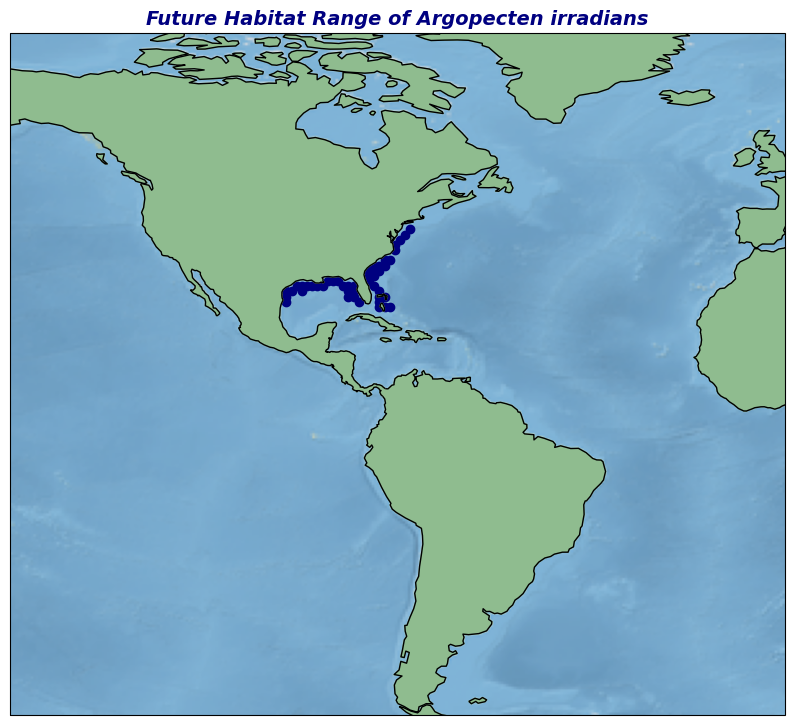

In [73]:
# Future Habitat range using same environmental indexing ranges
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()
ax.add_feature(cfeature.COASTLINE,zorder=11)
ax.add_feature(cfeature.LAND, zorder=10, color='darkseagreen')

P = ax.plot(lons[fut_habitat_index],lats[fut_habitat_index],'ro',color='navy',
                  transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent(
    [-150, 0, -20, 50])
 
plt.setp(ax.spines.values(), color='black',zorder=12)
pos = ax.get_position()
plt.title('Future Habitat Range of Argopecten irradians', fontweight='bold', fontstyle='italic', color='navy', fontsize=14)

In [67]:
total_habitat_area_fut = np.sum(area[fut_habitat_index])

In [68]:
total_habitat_area_fut

488579630000.0

In [69]:
# Finding the percent decline in total area of "suitable habitat"
100*(total_habitat_area_fut-his_total_habitat_area)/(his_total_habitat_area)

-59.95415894502189